In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# halo catalog
import h5py
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
halo_fname = 'abacus/RShalos_allprops.hdf5'
halo_path = os.path.join(project_path,halo_fname)
f = h5py.File(halo_path,'r')
halos = f['halos']
print(halos.dtype)
mass = halos['m'] # which mass is this?

[('id', '<i8'), ('parent_id', '<i8'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('corevel', '<f4', (3,)), ('bulkvel', '<f4', (3,)), ('m', '<f4'), ('m_SO', '<f4'), ('r', '<f4'), ('child_r', '<f4'), ('vmax_r', '<f4'), ('mgrav', '<f4'), ('vmax', '<f4'), ('rvmax', '<f4'), ('rs', '<f4'), ('klypin_rs', '<f4'), ('vrms', '<f4'), ('J', '<f4', (3,)), ('energy', '<f4'), ('spin', '<f4'), ('alt_m', '<f4', (4,)), ('alt_m_SO', '<f4', (4,)), ('Xoff', '<f4'), ('Voff', '<f4'), ('b_to_a', '<f4'), ('c_to_a', '<f4'), ('A', '<f4', (3,)), ('b_to_a2', '<f4'), ('c_to_a2', '<f4'), ('A2', '<f4', (3,)), ('bullock_spin', '<f4'), ('kin_to_pot', '<f4'), ('m_pe_b', '<f4'), ('m_pe_d', '<f4'), ('halfmass_radius', '<f4'), ('num_p', '<i8'), ('num_child_particles', '<i8'), ('p_start', '<i8'), ('desc', '<i8'), ('flags', '<i8'), ('n_core', '<i8'), ('subsamp_start', '<i8'), ('subsamp_len', '<i8'), ('min_pos_err', '<f4'), ('min_vel_err', '<f4'), ('min_bulkvel_err', '<f4'), ('N', '<i4'), ('alt_N', '<i4', (4,)), ('N_SO', '<i4

In [16]:
sel = mass > 1e+13 #only use the most massive halos
#plt.hist(np.log10(mass[sel]))
#plt.yscale('log')
lnM = np.log(mass[sel])
nh = len(lnM)

In [17]:
## scaling relation
Alam = 0.939
Blam = 0.32
Mpiv = 5e+14
z = 0.3
#lnlam_mean = lnlam0 + Alam * (lnM - np.log(Mpiv)) + Blam * np.log((1+z)/1.45)
lnlam0 = 4.25 - Alam * np.log(Mpiv) + Blam * np.log((1+z)/1.45)
lnlam_mean = lnlam0 + Alam * lnM

lnASZ = np.log(5.24)
BSZ = 1.534
CSZ = 0.465

# 0.161
lnSZ_mean = lnASZ + BSZ * (lnM - np.log(4.3e+14)) + CSZ * np.log(1) # TODO

import copy
lnMwl_mean = copy.deepcopy(lnM)

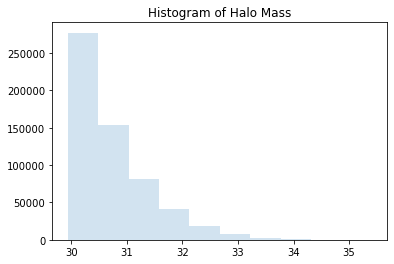

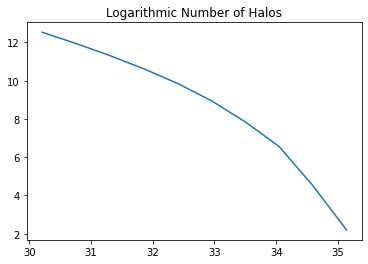

In [29]:
## calculate local slope
hist_data = plt.hist(lnM, alpha=0.2, bins=10)
plt.title("Histogram of Halo Mass")

n = np.log(hist_data[0]) #numbers in each bin
bins = hist_data[1] 
bins = 0.5*(bins[0:-1]+bins[1:])
plt.figure()
plt.plot(bins, n)
plt.title("Logarithmic Number of Halos")

bin_mid = []
slope_mid = []
for i in range(len(bins)-1):
    bin_mid.append(0.5*(bins[i+1] + bins[i]))
    slope = (n[i+1] - n[i])/(bins[i+1] - bins[i])
    slope_mid.append(-slope)
    
bin_mid.append(np.log(1e16))
slope_mid.append(0)

from scipy.interpolate import interp1d
mf_slope_interp = interp1d(bin_mid, slope_mid)


In [30]:
mf_slope_interp(np.log(1e+14))

array(1.44846671)

(0.0, 5.0)

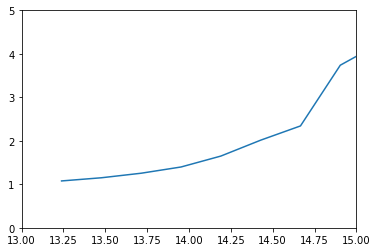

In [32]:
plt.plot(np.log10(np.exp(bin_mid)),slope_mid)
plt.xlim(13,15)
plt.ylim(0,5)

In [26]:
print(bin_mid)

[30.04556655883789, 30.15510368347168, 30.26464080810547, 30.374177932739258, 30.483715057373047, 30.593252182006836, 30.702789306640625, 30.81232452392578, 30.921863555908203, 31.03139877319336, 31.14093589782715, 31.250473022460938, 31.360010147094727, 31.469547271728516, 31.579084396362305, 31.688621520996094, 31.798158645629883, 31.907695770263672, 32.01723098754883, 32.12677001953125, 32.236305236816406, 32.34584426879883, 32.455379486083984, 32.564918518066406, 32.67445373535156, 32.783992767333984, 32.89352798461914, 33.00306701660156, 33.11260223388672, 33.22214126586914, 33.3316764831543, 33.44121551513672, 33.550750732421875, 33.66028594970703, 33.76982498168945, 33.87936019897461, 33.98889923095703, 34.09843444824219, 34.20797348022461, 34.317508697509766, 34.42704772949219, 34.536582946777344, 34.646121978759766, 34.75565719604492, 34.865196228027344, 34.9747314453125, 35.08427047729492, 35.19380569458008, 35.3033447265625, 36.841361487904734]


In [7]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [8]:
class MonteCarloObservables(object):
    def __init__(self, r, scatter_wl=0.2, scatter_lam=0.3, scatter_SZ=0.151):
        self.r = r
        self.scatter_wl = scatter_wl
        self.scatter_lam = scatter_lam
        self.scatter_SZ = scatter_SZ
        #mean and covariance matrix
        mv = multivariate_normal([0, 0], [[1, r], [r, 1]])
        rv = mv.rvs(size=nh)
        x = rv[:,0]
        y = rv[:,1] #does this work? 

        gauss = norm(0, 1)
        z = gauss.rvs(size=nh)

        self.lnlam = lnlam_mean + scatter_lam * x
        self.lnMwl = lnMwl_mean + scatter_wl * y
        self.lnSZ = lnSZ_mean + scatter_SZ * z

        
    def selecting_lambda_matching_mass(self, lnlam_min=np.log(20), lnlam_max=np.log(30)):
        sel = (self.lnlam > lnlam_min)&(self.lnlam < lnlam_max) # select on a lambda bin
        lnMwl_sel = np.mean(self.lnMwl[sel]) # calculate the mean Mwl in the lambda bin

        lnM_sel = lnM[sel] # calculate the mean M500c in the lambda bin 
        nbins = 100
        lnMbins = np.linspace(min(lnM_sel)-0.1, max(lnM_sel)+0.1, nbins+1) #divide up the selected M500c bin

        lnMwl_weighted = 0 # empty variable
        
        for i in range(nbins):
            lnMmin = lnMbins[i]  #Mbin min
            lnMmax = lnMbins[i+1] #Mbin max
            sel2 = (lnM_sel >= lnMmin)&(lnM_sel < lnMmax) # Mbin amsk
            weight = len(lnM_sel[sel2])/len(lnM_sel) # mass PDF of halos selected on richness
            
            if weight > 0:
                sel3 = (lnM >= lnMmin)&(lnM < lnMmax) 
                lnMwl_weighted += np.mean(self.lnMwl[sel3]) * weight #weighted real Mwl

        theory = self.r * self.scatter_wl * (self.lnlam - lnlam_mean)/self.scatter_lam 
        theory = np.mean(theory[sel])

        return lnMwl_sel-lnMwl_weighted, theory  
    

    def selecting_lambda_matching_SZ(self, lnlam_min=np.log(20), lnlam_max=np.log(30)):
        sel = (self.lnlam > lnlam_min)&(self.lnlam < lnlam_max)
        lnMwl_sel = np.mean(self.lnMwl[sel])

        lnSZ_sel = self.lnSZ[sel]
        nbins = 100
        lnSZbins = np.linspace(min(lnSZ_sel)-0.1, max(lnSZ_sel)+0.1, nbins+1)

        lnMwl_weighted = 0
        for i in range(nbins):
            lnSZmin = lnSZbins[i]
            lnSZmax = lnSZbins[i+1]
            sel2 = (lnSZ_sel >= lnSZmin)&(lnSZ_sel < lnSZmax) # lambda selected
            weight = len(lnSZ_sel[sel2])/len(lnSZ_sel)
            if weight > 0:
                sel3 = (self.lnSZ >= lnSZmin)&(self.lnSZ < lnSZmax) # all lambda
                lnMwl_weighted += np.mean(self.lnMwl[sel3]) * weight

        theory = self.r * self.scatter_wl * (self.lnlam - lnlam_mean)/self.scatter_lam 
        beta = 1.77 # slope at 1e14 #TODO
        theory = np.mean(theory[sel]) + beta * (self.scatter_SZ / BSZ)**2 

        return lnMwl_sel-lnMwl_weighted, theory  
        
    def selecting_SZ_matching_lambda(self, SZ_cut=np.log(4)): 
        sel = (self.lnSZ > SZ_cut)
        lnMwl_sel = np.mean(self.lnMwl[sel])

        lnlam_sel = self.lnlam[sel]
        nbins = 100
        lnlam_bins = np.linspace(min(lnlam_sel)-0.1, max(lnlam_sel)+0.1, nbins+1)

        lnMwl_weighted = 0
        mean_mass_theory = 0 # make pred one bin at a time

        for i in range(nbins):
            lnlam_min = lnlam_bins[i]
            lnlam_max = lnlam_bins[i+1]
            sel2 = (lnlam_sel >= lnlam_min)&(lnlam_sel < lnlam_max)
            weight = len(lnlam_sel[sel2])/len(lnlam_sel)
            if weight > 0:
                sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
                lnMwl_weighted += np.mean(self.lnMwl[sel3]) * weight
        
#                 lnM_expected = (self.lnlam[sel3]-lnlam0) / Alam
#                 beta = mf_slope_interp(lnM_expected)
#                 pred = lnM_expected - beta * (self.scatter_lam / Alam)**2 
#                 pred = np.mean(pred)
#                 mean_mass_theory += pred * weight

        theory = self.r * self.scatter_wl * (self.lnlam - lnlam_mean)/self.scatter_lam 
        beta = 1.77 # slope at 1e14 #TODO
        theory = np.mean(theory[sel]) + beta * (self.scatter_lam / Alam)**2 
        #theory = -np.mean(theory[sel]) + beta * (self.scatter_SZ / BSZ)**2 

                
        return lnMwl_sel, lnMwl_weighted, theory # TODO: This theory doesn't work  

In [9]:
## selecting on SZ, matching lambda ## NOT WORKING
nr = 10
rlist = np.linspace(0, 0.99, nr)
lnMwl_sel_list = np.zeros(nr)
lnMwl_weighted_list = np.zeros(nr)
lnMwl_theory_list = np.zeros(nr)

for ir in range(nr):
    mco = MonteCarloObservables(rlist[ir])
    lnMwl_sel, lnMwl_weighted, lnMwl_theory = mco.selecting_SZ_matching_lambda()
    lnMwl_sel_list[ir] = lnMwl_sel
    lnMwl_weighted_list[ir] = lnMwl_weighted
    lnMwl_theory_list[ir] = lnMwl_theory

fig = plt.figure(figsize=(10,7))

plt.plot(rlist, lnMwl_sel_list - lnMwl_weighted_list, label='numerical')
#plt.plot(rlist, lnMwl_theory_list, label='theory')

plt.xlabel('r')
plt.ylabel(r'frac diff in $\rm M_{wl}$')
plt.title(r'$\rm \sigma_{wl}=0.1, \sigma_{\lambda}=0.3,  \sigma_{SZ}=0.15$')

/global/homes/z/zchusre/.conda/envs/spt_selection/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/z/zchusre/.conda/envs/spt_selection/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: min() arg is an empty sequence

## selecting $\lambda$, matching mass

In [ ]:
nr = 10
rlist = np.linspace(0, 0.99, nr)
diff_obs_list = np.zeros(nr)
diff_theory_list = np.zeros(nr)

for ir in range(nr):
    mco = MonteCarloObservables(rlist[ir])
    diff_obs_list[ir], diff_theory_list[ir] = mco.selecting_lambda_matching_mass()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1], wspace=0, hspace=0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(rlist, diff_obs_list, label='numerical')
ax1.plot(rlist, diff_theory_list, label='theory')
ax1.set_ylabel(r'$\rm lnM_{wl}$ bias')
ax1.legend()
ax1.set_title(r'selecting $\lambda$, matching mass')

diff_diff = diff_obs_list - diff_theory_list
ax2.plot(rlist, diff_diff)
ax2.axhline(0, c='gray', ls='--')
ax2.set_xlabel('r')
ax2.set_ylabel('diff')
ax2.set_ylim(-max(abs(diff_diff))*2, max(abs(diff_diff))*2)
plt.show()

## selecting $\lambda$, matching SZ

In [ ]:
nr = 10
rlist = np.linspace(0, 0.99, nr)
diff_obs_list = np.zeros(nr)
diff_theory_list = np.zeros(nr)

for ir in range(nr):
    mco = MonteCarloObservables(rlist[ir])
    diff_obs_list[ir], diff_theory_list[ir] = mco.selecting_lambda_matching_SZ()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1], wspace=0, hspace=0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(rlist, diff_obs_list, label='numerical')
ax1.plot(rlist, diff_theory_list, label='theory')
ax1.set_ylabel(r'$\rm lnM_{wl}$ bias')
ax1.legend()
ax1.set_title(r'selecting $\lambda$, matching SZ')

diff_diff = diff_obs_list - diff_theory_list
ax2.plot(rlist, diff_diff)
ax2.axhline(0, c='gray', ls='--')
ax2.set_xlabel('r')
ax2.set_ylabel('diff')
ax2.set_ylim(-max(abs(diff_diff))*2, max(abs(diff_diff))*2)
plt.show()

In [2]:
import numpy as np
np.exp(0.5)

1.6487212707001282

In [3]:
np.log(1E14)

32.23619130191664